<a href="https://colab.research.google.com/github/LetitiaP/Covid-19-Impact-Study/blob/main/Capstone_3__Covid_19_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction

##The purpose of this project is to investigate the impact of Covid-19 and behavioral patterns that are intended to prevent viral spread.
---
###Target Audience
The findings generated by this project will be valuable to anyone seeking insight into the covid-19 pandemic. Specific targeting is directed toward local governments, and businesses seeking information to shape Covid-19 policies.

---
###This project will utilize three datasets:

####Imperial College of London - [Covid-19 Behavior Tracker](https://github.com/YouGov-Data/covid-19-tracker)
- Located using the Data is Plural [archives](https://docs.google.com/spreadsheets/d/1wZhPLMCHKJvwOkP4juclhjFgqIY8fQFMemwKL2c64vk/edit?usp=sharing)


> " Since early April, Imperial College London and YouGov have been surveying people in 29 countries about their coronavirus-related behaviors and opinions. Topics include mask usage, self-isolation, working from home, vaccinations, and economic activity; the 230,000+ (anonymized) responses are available to download. [h/t Akin Unver] "



####CDC Covid-19 Case Surveillance - [Public Use Data](https://data.cdc.gov/Case-Surveillance/COVID-19-Case-Surveillance-Public-Use-Data/vbim-akqf)
- Located using the Data is Plural [archives](https://docs.google.com/spreadsheets/d/1wZhPLMCHKJvwOkP4juclhjFgqIY8fQFMemwKL2c64vk/edit?usp=sharing)

> " The US Centers for Disease Control and Prevention has published a dataset containing demographic and medical information on 1.75 million deidentified COVID-19 patients. For each confirmed or probable case, the dataset report reports the patient’s age group and race/ethnicity, the date of their initial symptoms, whether they were hospitalized, whether they had an “underlying morbidity or disease,” and more — although several of the fields contain high percentages of “unknown” values. The dataset is similar to the one The New York Times got from the CDC through a Freedom of Information Act lawsuit (see: “The Fullest Look Yet at the Racial Inequity of Coronavirus”), but it does not specify the patient’s county. [h/t Marc Bevand + Steven Mosher] "

####US Census - [Quick Facts](https://www.census.gov/quickfacts/fact/table/US/PST045219) - data set stored in G-drive [here](https://drive.google.com/drive/folders/19zco_U3hj_PgMvxwJTbWaJES--uHQ9Uh?usp=sharing)
* Accessed directly by me for use with this project


---
##The two hypotheses driving this project are:

1. Covid cases increase in correlation with relaxing covid-19 behaviors
2. POC are impacted more strongly by covid-19, as measured by hospitalization, ICU admission, and death rates.

#Initial Library and Data imports

##Library imports

In [ ]:
#To keep the page organized, do all the imports at once
!pip install sodapy

from sqlalchemy import create_engine
from sqlalchemy import inspect
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
from sodapy import Socrata
from scipy import stats
from scipy.stats import norm
from datetime import datetime

#Mount Gdrive to Colab
from google.colab import drive
drive.mount('/content/gdrive')

#Supress warnings (warnings to not prevent a code from excecuting)
import warnings
warnings.filterwarnings('ignore')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


##Covid-19 Behavior data

In [ ]:
#Import USA behaviors from the Covid-19 behavior data sets
#Need to use the link to the raw data, not to the github GUI page
covid_behaviors_USA = pd.read_csv(
    'https://raw.githubusercontent.com/YouGov-Data/covid-19-tracker/master/data/united-states.csv')

In [ ]:
#Take a look at the data
covid_behaviors_USA.info()

#Info isn't returning usual output... too many columns I think.
#Check the first few rows with head
covid_behaviors_USA.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16982 entries, 0 to 16981
Columns: 323 entries, RecordNo to disability
dtypes: float64(1), int64(6), object(316)
memory usage: 41.8+ MB


,RecordNo,endtime,state,qweek,i1_health,i2_health,i7a_health,i3_health,i4_health,i5_health_1,i5_health_2,i5_health_3,i5_health_4,i5_health_5,i5_health_99,i5a_health,i6_health,i7b_health,i8_health,i9_health,i10_health,i11_health,i12_health_1,i12_health_2,i12_health_3,i12_health_4,i12_health_5,i12_health_6,i12_health_7,i12_health_8,i12_health_9,i12_health_10,i12_health_11,i12_health_12,i12_health_13,i12_health_14,i12_health_15,i12_health_16,i12_health_17,i12_health_18,...,w3,w4_1,w4_2,w4_3,w4_4,w4_5,w4_6,w4_7,w4_8,w4_9,w4_10,w4_11,w4_99,w4b,w5_1,w5_2,w5_3,w5_4,w5_5,w5_6,w5_7,w5_8,w5_9,w5_10,w5_11,w5_12,w5_13,w5_14,w5_15,w5_16,w5_96,w5_99,w6,w7,w9_1,w9_2,w9_3,w9_4,w9_5,disability
0,0,02/04/2020 08:11,California,week 1,5,7,0,"No, I have not",,,,,,,,,,,,Not sure,Neither easy nor difficult,Somewhat willing,Frequently,Always,Sometimes,Sometimes,Rarely,Sometimes,Rarely,Frequently,,Always,Rarely,Not at all,Not at all,Rarely,Rarely,Frequently,Rarely,Sometimes,...,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1,02/04/2020 08:12,Pennsylvania,week 1,3,4,0,"No, I have not","No, they have not",No,No,No,No,No,Yes,,,,,Yes,Very easy,Very willing,Rarely,Always,Frequently,Always,Always,Frequently,Always,Always,Frequently,Always,Frequently,Frequently,Always,Always,Always,Frequently,Not at all,Frequently,...,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,2,02/04/2020 08:15,Florida,week 1,1,12,0,"No, I have not","No, they have not",Yes,No,No,No,No,No,Not sure,Frequently,No,Not sure,Yes,Somewhat difficult,Very willing,Not at all,Always,Always,Always,Always,Frequently,Always,Always,Always,,Always,Always,Always,Always,Always,Frequently,Not at all,Not at all,...,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3,3,02/04/2020 08:15,California,week 1,5,8,1,"No, I have not","No, they have not",No,No,No,No,No,Yes,,,,,Yes,Somewhat difficult,Somewhat willing,Not at all,Frequently,Not at all,Always,Always,Frequently,Frequently,Always,,,Always,Sometimes,Frequently,Always,Frequently,Sometimes,Not at all,Sometimes,...,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4,4,02/04/2020 08:15,Florida,week 1,1,1,0,"No, I have not","No, they have not",Yes,No,No,No,No,No,No,Always,No,No,Yes,Somewhat easy,Very willing,Always,Always,Sometimes,Always,Always,Always,Always,Always,,,Always,Always,Always,Always,Always,Always,Not at all,Always,...,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


##CDC Case Data
This data set is large, occasionally runtime crashes, just rerun again

In [ ]:
#Utilizing the publically accessible data so that anyone can run this book
#The request will be throttled, but it doesn't take too long
#If runtime crashes, run again, this happens occasionally, likely from throttling
#I considered copying data to csv, but I like that this way the data updates over time

# For a public data set use 'None' # in place of application token
# and no username or password:
client = Socrata("data.cdc.gov", None)

# Can add limit clause to only pull a certain amount ex .get('source', limit = #)
#Default return is 1000 rows, so be sure to specify
#I am pulling 3.6M because that will give me data through mid august.
#This request could be updated in the future as more data is added
results = client.get("vbim-akqf", limit =3660000)

# Convert to pandas DataFrame
covid_results_df = pd.DataFrame.from_records(results)

In [ ]:
#Check the df info and get the first few rows
covid_results_df.info()

covid_results_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3660000 entries, 0 to 3659999
Data columns (total 11 columns):
 #   Column                   Dtype 
---  ------                   ----- 
 0   cdc_report_dt            object
 1   pos_spec_dt              object
 2   onset_dt                 object
 3   current_status           object
 4   sex                      object
 5   age_group                object
 6   race_ethnicity_combined  object
 7   hosp_yn                  object
 8   icu_yn                   object
 9   death_yn                 object
 10  medcond_yn               object
dtypes: object(11)
memory usage: 307.2+ MB


,cdc_report_dt,pos_spec_dt,onset_dt,current_status,sex,age_group,race_ethnicity_combined,hosp_yn,icu_yn,death_yn,medcond_yn
0,2020-03-22T00:00:00.000,2020-03-15T00:00:00.000,2020-03-11T00:00:00.000,Laboratory-confirmed case,Female,0 - 9 Years,"Multiple/Other, Non-Hispanic",Yes,Yes,No,Yes
1,2020-03-23T00:00:00.000,2020-03-15T00:00:00.000,NaN,Laboratory-confirmed case,Female,0 - 9 Years,Unknown,Unknown,Unknown,Unknown,Unknown
2,2020-03-15T00:00:00.000,2020-03-15T00:00:00.000,NaN,Laboratory-confirmed case,Female,0 - 9 Years,Unknown,Missing,Missing,Missing,Missing
3,2020-03-15T00:00:00.000,2020-03-15T00:00:00.000,NaN,Laboratory-confirmed case,Female,0 - 9 Years,Unknown,Missing,Missing,Missing,Missing
4,2020-03-15T00:00:00.000,2020-03-15T00:00:00.000,NaN,Laboratory-confirmed case,Female,0 - 9 Years,Unknown,Missing,Missing,Missing,Missing


In [ ]:
#Find unique values for age_group so that I can set up a column in behaviors
#That will match CDC age ranges
age_categories = covid_results_df.age_group.unique()
print(age_categories)

#Ended up not utilizing age groups in this analysis, but I am keeping this code here
#Since I did add the age groups to the covid_behaviors dataframe

['0 - 9 Years' '10 - 19 Years' '20 - 29 Years' '30 - 39 Years'
 '50 - 59 Years' '60 - 69 Years' '70 - 79 Years' '40 - 49 Years'
 '80+ Years']


##US Census Data


In [ ]:
#Downloaded csv file of census data and stored in my G-drive
#This data isn't actively being updated so I'm fine having static data here
census_data = pd.read_csv('/content/gdrive/My Drive/Thinkful/Assignments/Capstone 3/Colab Datasets/QuickFacts Oct-01-2020.csv')
census_data.head(16)

#I need this data for hypothesis 2

,Fact,Fact Note,United States,Value Note for United States
0,"Population estimates, July 1, 2019, (V2019)",NaN,"328,239,523",NaN
1,"Population estimates base, April 1, 2010, (V2...",NaN,"308,758,105",NaN
2,"Population, percent change - April 1, 2010 (es...",NaN,6.3%,NaN
3,"Population, Census, April 1, 2010",NaN,"308,745,538",NaN
4,"Persons under 5 years, percent",NaN,6.0%,NaN
5,"Persons under 18 years, percent",NaN,22.3%,NaN
6,"Persons 65 years and over, percent",NaN,16.5%,NaN
7,"Female persons, percent",NaN,50.8%,NaN
8,"White alone, percent",NaN,76.3%,NaN
9,"Black or African American alone, percent",(a),13.4%,NaN


#Data cleaning and filtering
---
See comments in markdown boxes below for summaries, and details, about filtering methods

##Covid-19 Behavior Data

It isn't feasible to look at all of these values for this project. While all of these values will have some impact on covid cases, I am going to only select two behavior types to focus on.

* Mask use - Wearing masks is a strategy for stopping the spread of airporn particles.
* Gathering size - focus on the 3to10, and 10plus gatherings. More interaction leads to greter exposure (Look at 3to10 and 10plus)

I have also added a column that contains the weeks of the year (to allow chronological comparrison with the CDC data), and changed the original responses (Always, Sometimes, Never) to numeric values so that they can be plotted.




###Initial Data Filtering
There is A LOT of information in this data set.  Using the codebook (found at the link provided above, and in the g-drive folder that the cdc data is from), I have narrowed the data to 25 responses. This data falls into 4 main types:
* Record information, such as id, date, and state
* Demographic information, such as gender, age, household, and employment
* Hygiene covid behaviors, such as masks, handwashing, covering mouths
* Avoidance covid behaviors, such as avoiding gatherings, staying home, etc.

In [ ]:
#First, rename some of the columums of interest to make this more readable
covid_behaviors_USA.rename(columns = {'i12_health_1':'mask', 'i12_health_2':'soap_water', 
    'i12_health_3':'hand_sanitizer', 'i12_health_4':'cover_mouth', 'i12_health_5':'avoid_sick',
    'i12_health_6':'avoid_going_out', 'i12_health_8':'avoid_transit',
    'i12_health_9':'avoid_wfo', 'i12_health_10':'avoid_school', 'i12_health_11':'avoid_guests',
    'i12_health_12':'avoid_gatherings_2', 'i12_health_13':'avoid_gatherings_3to10', 
    'i12_health_14':'avoid_gatherings_10plus', 'i12_health_15':'avoid_crowds', 
    'i12_health_16':'avoid_shops', 'i12_health_20':'avoid_touch'}, inplace = True) 

In [ ]:
#Now, select only the 25 columns that I want to look at
select_covid_behaviors = covid_behaviors_USA[['RecordNo','endtime', 'state', 'qweek',
    'gender', 'age', 'household_size', 'household_children', 'employment_status',
    'mask', 'soap_water', 'hand_sanitizer', 'cover_mouth', 'avoid_sick',
    'avoid_going_out', 'avoid_transit','avoid_wfo', 'avoid_school', 'avoid_guests',
    'avoid_gatherings_2', 'avoid_gatherings_3to10', 'avoid_gatherings_10plus',
    'avoid_crowds', 'avoid_shops', 'avoid_touch']]

In [ ]:
#Check the new dataframe
select_covid_behaviors.info()
select_covid_behaviors.head()
#Note, all the categories I selected don't have null values.  Yay!

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16982 entries, 0 to 16981
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   RecordNo                 16982 non-null  int64 
 1   endtime                  16982 non-null  object
 2   state                    16982 non-null  object
 3   qweek                    16982 non-null  object
 4   gender                   16982 non-null  object
 5   age                      16982 non-null  int64 
 6   household_size           16982 non-null  object
 7   household_children       16982 non-null  object
 8   employment_status        16982 non-null  object
 9   mask                     16982 non-null  object
 10  soap_water               16982 non-null  object
 11  hand_sanitizer           16982 non-null  object
 12  cover_mouth              16982 non-null  object
 13  avoid_sick               16982 non-null  object
 14  avoid_going_out          16982 non-nul

,RecordNo,endtime,state,qweek,gender,age,household_size,household_children,employment_status,mask,soap_water,hand_sanitizer,cover_mouth,avoid_sick,avoid_going_out,avoid_transit,avoid_wfo,avoid_school,avoid_guests,avoid_gatherings_2,avoid_gatherings_3to10,avoid_gatherings_10plus,avoid_crowds,avoid_shops,avoid_touch
0,0,02/04/2020 08:11,California,week 1,Female,33,5,2,Not working,Frequently,Always,Sometimes,Sometimes,Rarely,Sometimes,Frequently,,Always,Rarely,Not at all,Not at all,Rarely,Rarely,Frequently,Rarely
1,1,02/04/2020 08:12,Pennsylvania,week 1,Male,38,4,1,Full time employment,Rarely,Always,Frequently,Always,Always,Frequently,Always,Frequently,Always,Frequently,Frequently,Always,Always,Always,Frequently,Frequently
2,2,02/04/2020 08:15,Florida,week 1,Female,48,2,0,Full time employment,Not at all,Always,Always,Always,Always,Frequently,Always,Always,,Always,Always,Always,Always,Always,Frequently,Frequently
3,3,02/04/2020 08:15,California,week 1,Male,31,5,0,Unemployed,Not at all,Frequently,Not at all,Always,Always,Frequently,Always,,,Always,Sometimes,Frequently,Always,Frequently,Sometimes,Frequently
4,4,02/04/2020 08:15,Florida,week 1,Female,69,2,0,Retired,Always,Always,Sometimes,Always,Always,Always,Always,,,Always,Always,Always,Always,Always,Always,Always


###Narrowing the scope
It isn't feasible to look at all of these values for this project. While all of these values will have some impact on covid cases, I am going to only select two behavior types to focus on. 
* Mask use - Wearing masks is a strategy for stopping the spread of airporn particles.
* Gathering size - focus on the 3to10, and 10plus gatherings.  More interaction leads to greter exposure (Look at 3to10 and 10plus)

I will also keep age and gender in case I have time to look at these.


In [ ]:
#Create a new, even smaller data frame that only includes record info, gender,
#age, mask, and avoid gatherings
limit_covid_behaviors = select_covid_behaviors[['RecordNo', 'endtime', 'state',
    'qweek', 'gender', 'age', 'mask', 'avoid_gatherings_3to10', 'avoid_gatherings_10plus']]

In [ ]:
#Inspect df
limit_covid_behaviors.info()
limit_covid_behaviors.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16982 entries, 0 to 16981
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   RecordNo                 16982 non-null  int64 
 1   endtime                  16982 non-null  object
 2   state                    16982 non-null  object
 3   qweek                    16982 non-null  object
 4   gender                   16982 non-null  object
 5   age                      16982 non-null  int64 
 6   mask                     16982 non-null  object
 7   avoid_gatherings_3to10   16982 non-null  object
 8   avoid_gatherings_10plus  16982 non-null  object
dtypes: int64(2), object(7)
memory usage: 1.2+ MB


,RecordNo,endtime,state,qweek,gender,age,mask,avoid_gatherings_3to10,avoid_gatherings_10plus
0,0,02/04/2020 08:11,California,week 1,Female,33,Frequently,Not at all,Rarely
1,1,02/04/2020 08:12,Pennsylvania,week 1,Male,38,Rarely,Always,Always
2,2,02/04/2020 08:15,Florida,week 1,Female,48,Not at all,Always,Always
3,3,02/04/2020 08:15,California,week 1,Male,31,Not at all,Frequently,Always
4,4,02/04/2020 08:15,Florida,week 1,Female,69,Always,Always,Always


####Adding Columns

#####Week of the year
In order to compare data with the CDC I need to create a column with weeks of the year.


In [ ]:
#Isolate the date portion of endtime
limit_covid_behaviors['date'] = limit_covid_behaviors.endtime.str[:10]

#Check df
limit_covid_behaviors.head(1)

,RecordNo,endtime,state,qweek,gender,age,mask,avoid_gatherings_3to10,avoid_gatherings_10plus,date
0,0,02/04/2020 08:11,California,week 1,Female,33,Frequently,Not at all,Rarely,02/04/2020


In [ ]:
#Use function to convert date string format to yyyy-mm-dd
def conv_dates_series(df, col, old_date_format, new_date_format):

    df[col] = pd.to_datetime(df[col], format=old_date_format).dt.strftime(new_date_format)

    return(df)

old_date_format='%d/%m/%Y'
new_date_format='%Y-%m-%d'

conv_dates_series(limit_covid_behaviors, "date", old_date_format, new_date_format)

,RecordNo,endtime,state,qweek,gender,age,mask,avoid_gatherings_3to10,avoid_gatherings_10plus,date
0,0,02/04/2020 08:11,California,week 1,Female,33,Frequently,Not at all,Rarely,2020-04-02
1,1,02/04/2020 08:12,Pennsylvania,week 1,Male,38,Rarely,Always,Always,2020-04-02
2,2,02/04/2020 08:15,Florida,week 1,Female,48,Not at all,Always,Always,2020-04-02
3,3,02/04/2020 08:15,California,week 1,Male,31,Not at all,Frequently,Always,2020-04-02
4,4,02/04/2020 08:15,Florida,week 1,Female,69,Always,Always,Always,2020-04-02
...,...,...,...,...,...,...,...,...,...,...
16977,16977,29/09/2020 04:57,Oklahoma,week 16,Female,27,Always,Always,Always,2020-09-29
16978,16978,29/09/2020 15:07,California,week 16,Female,74,Always,Always,Always,2020-09-29
16979,16979,29/09/2020 19:48,Rhode Island,week 16,Female,26,Not at all,Always,Always,2020-09-29
16980,16980,30/09/2020 04:17,Mississippi,week 16,Male,22,Sometimes,Sometimes,Sometimes,2020-09-30


In [ ]:
#convert 'date' string to datetime
limit_covid_behaviors['date'] = pd.to_datetime(limit_covid_behaviors['date'])

#Check df
limit_covid_behaviors.info()
limit_covid_behaviors.head(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16982 entries, 0 to 16981
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   RecordNo                 16982 non-null  int64         
 1   endtime                  16982 non-null  object        
 2   state                    16982 non-null  object        
 3   qweek                    16982 non-null  object        
 4   gender                   16982 non-null  object        
 5   age                      16982 non-null  int64         
 6   mask                     16982 non-null  object        
 7   avoid_gatherings_3to10   16982 non-null  object        
 8   avoid_gatherings_10plus  16982 non-null  object        
 9   date                     16982 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(7)
memory usage: 1.3+ MB


,RecordNo,endtime,state,qweek,gender,age,mask,avoid_gatherings_3to10,avoid_gatherings_10plus,date
0,0,02/04/2020 08:11,California,week 1,Female,33,Frequently,Not at all,Rarely,2020-04-02


In [ ]:
#Create a year_week column as the first step in isolating the week
limit_covid_behaviors['y_w'] = limit_covid_behaviors['date'].apply(lambda x: '{0}-{1}'.format(x.year, x.isocalendar()[1]))

#Isolate just the week
limit_covid_behaviors['week'] = limit_covid_behaviors.y_w.str[5:]

#Convert the week column to int
limit_covid_behaviors['week'] = limit_covid_behaviors['week'].astype(int)

#Check df
limit_covid_behaviors.info()
limit_covid_behaviors.head(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16982 entries, 0 to 16981
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   RecordNo                 16982 non-null  int64         
 1   endtime                  16982 non-null  object        
 2   state                    16982 non-null  object        
 3   qweek                    16982 non-null  object        
 4   gender                   16982 non-null  object        
 5   age                      16982 non-null  int64         
 6   mask                     16982 non-null  object        
 7   avoid_gatherings_3to10   16982 non-null  object        
 8   avoid_gatherings_10plus  16982 non-null  object        
 9   date                     16982 non-null  datetime64[ns]
 10  y_w                      16982 non-null  object        
 11  week                     16982 non-null  int64         
dtypes: datetime64[ns](1), int64(3), 

,RecordNo,endtime,state,qweek,gender,age,mask,avoid_gatherings_3to10,avoid_gatherings_10plus,date,y_w,week
0,0,02/04/2020 08:11,California,week 1,Female,33,Frequently,Not at all,Rarely,2020-04-02,2020-14,14


#####Age_group

In [ ]:
#Convert the age_categories array from CDC case data into a list
age_list = age_categories.tolist()

age_list

['0 - 9 Years',
 '10 - 19 Years',
 '20 - 29 Years',
 '30 - 39 Years',
 '50 - 59 Years',
 '60 - 69 Years',
 '70 - 79 Years',
 '40 - 49 Years',
 '80+ Years']

In [ ]:
#Remove unknown and NA values from list so that I can use it to create a new column
del age_list[9:]

age_list

['0 - 9 Years',
 '10 - 19 Years',
 '20 - 29 Years',
 '30 - 39 Years',
 '50 - 59 Years',
 '60 - 69 Years',
 '70 - 79 Years',
 '40 - 49 Years',
 '80+ Years']

In [ ]:
#CDC data groups ages in 10 year chunks.  Add a column that creates this grouping
#First set up bins to tell pandas where to cut the data
#start at 0 then add numbers where every cut should happen (non-inclusive)
bins= [0,10,20,30,40, 50, 60, 70, 80, 120]
#Use the list that was generated from the CDC data
limit_covid_behaviors['age_group'] = pd.cut(limit_covid_behaviors['age'], bins=bins, labels=age_list, right=False)

limit_covid_behaviors.head()

,RecordNo,endtime,state,qweek,gender,age,mask,avoid_gatherings_3to10,avoid_gatherings_10plus,date,y_w,week,age_group
0,0,02/04/2020 08:11,California,week 1,Female,33,Frequently,Not at all,Rarely,2020-04-02,2020-14,14,30 - 39 Years
1,1,02/04/2020 08:12,Pennsylvania,week 1,Male,38,Rarely,Always,Always,2020-04-02,2020-14,14,30 - 39 Years
2,2,02/04/2020 08:15,Florida,week 1,Female,48,Not at all,Always,Always,2020-04-02,2020-14,14,50 - 59 Years
3,3,02/04/2020 08:15,California,week 1,Male,31,Not at all,Frequently,Always,2020-04-02,2020-14,14,30 - 39 Years
4,4,02/04/2020 08:15,Florida,week 1,Female,69,Always,Always,Always,2020-04-02,2020-14,14,70 - 79 Years


####Converting string values to numeric values
I would like to have numbers to allow for some basic visualization of the data. 
* Always = 10
* Frequently = 8
* Sometimes = 5
* Rarely = 2
* Not at all = 0

In [ ]:
#This will replace all instances of the string inputs with numeric inputs
numeric_covid_behaviors = limit_covid_behaviors.replace(
    to_replace=['Always', 'Frequently', 'Sometimes', 'Rarely', 'Not at all'],
    value= [10, 8, 5, 2, 0])

numeric_covid_behaviors.info()
numeric_covid_behaviors.head(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16982 entries, 0 to 16981
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   RecordNo                 16982 non-null  int64         
 1   endtime                  16982 non-null  object        
 2   state                    16982 non-null  object        
 3   qweek                    16982 non-null  object        
 4   gender                   16982 non-null  object        
 5   age                      16982 non-null  int64         
 6   mask                     16982 non-null  int64         
 7   avoid_gatherings_3to10   16982 non-null  int64         
 8   avoid_gatherings_10plus  16982 non-null  int64         
 9   date                     16982 non-null  datetime64[ns]
 10  y_w                      16982 non-null  object        
 11  week                     16982 non-null  int64         
 12  age_group                16982 n

,RecordNo,endtime,state,qweek,gender,age,mask,avoid_gatherings_3to10,avoid_gatherings_10plus,date,y_w,week,age_group
0,0,02/04/2020 08:11,California,week 1,Female,33,8,0,2,2020-04-02,2020-14,14,30 - 39 Years


##Census Data

I only need the 2019 population estimate and the population percentage for Black, Hispanic, and White Americans.  

Population frequency was used to generate counts of each racial population for later use in the z tests

###Filter data to only keep race

In [ ]:
census_data.head(16)

,Fact,Fact Note,United States,Value Note for United States
0,"Population estimates, July 1, 2019, (V2019)",NaN,"328,239,523",NaN
1,"Population estimates base, April 1, 2010, (V2...",NaN,"308,758,105",NaN
2,"Population, percent change - April 1, 2010 (es...",NaN,6.3%,NaN
3,"Population, Census, April 1, 2010",NaN,"308,745,538",NaN
4,"Persons under 5 years, percent",NaN,6.0%,NaN
5,"Persons under 18 years, percent",NaN,22.3%,NaN
6,"Persons 65 years and over, percent",NaN,16.5%,NaN
7,"Female persons, percent",NaN,50.8%,NaN
8,"White alone, percent",NaN,76.3%,NaN
9,"Black or African American alone, percent",(a),13.4%,NaN


In [ ]:
#Limit the rows of the frame to those with racial data
census_race_all = census_data.iloc[8:16]
#Limit the columns of the frame to those with values of interest
census_race = census_race_all[['Fact', 'United States']]

census_race

,Fact,United States
8,"White alone, percent",76.3%
9,"Black or African American alone, percent",13.4%
10,"American Indian and Alaska Native alone, percent",1.3%
11,"Asian alone, percent",5.9%
12,Native Hawaiian and Other Pacific Islander alo...,0.2%
13,"Two or More Races, percent",2.8%
14,"Hispanic or Latino, percent",18.5%
15,"White alone, not Hispanic or Latino, percent",60.1%


###Further manipulation of DF

Only races of interest, and added column for frequency as a float

In [ ]:
#Create Frame that only has the three races that are applicable for this project
census_race_bhw = census_race.iloc[[1, 6, 7]]

census_race_bhw.info()

census_race_bhw

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3 entries, 9 to 15
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Fact           3 non-null      object
 1   United States  3 non-null      object
dtypes: object(2)
memory usage: 72.0+ bytes


,Fact,United States
9,"Black or African American alone, percent",13.4%
14,"Hispanic or Latino, percent",18.5%
15,"White alone, not Hispanic or Latino, percent",60.1%


In [ ]:
#Rename United states column to population
census_race_bhw.rename(columns={'United States':'population'}, inplace=True)

#Create extra column to have just the frequency
census_race_bhw['pop_float'] = census_race_bhw.population.str[:4]

#store pop_int as a float
census_race_bhw['pop_float'] = census_race_bhw['pop_float'].astype(float)

#Create another column to have frequency in decimal form
census_race_bhw = census_race_bhw.assign(pop_dec = (census_race_bhw.pop_float/100) )

#Check
census_race_bhw.info()
census_race_bhw

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3 entries, 9 to 15
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Fact        3 non-null      object 
 1   population  3 non-null      object 
 2   pop_float   3 non-null      float64
 3   pop_dec     3 non-null      float64
dtypes: float64(2), object(2)
memory usage: 120.0+ bytes


,Fact,population,pop_float,pop_dec
9,"Black or African American alone, percent",13.4%,13.4,0.134
14,"Hispanic or Latino, percent",18.5%,18.5,0.185
15,"White alone, not Hispanic or Latino, percent",60.1%,60.1,0.601


####Population of US

In [ ]:
#Isolate 2019 population
census_race_population = census_data.iloc[0:1]

census_race_population

,Fact,Fact Note,United States,Value Note for United States
0,"Population estimates, July 1, 2019, (V2019)",NaN,"328,239,523",NaN


In [ ]:
# Store population count for US 2019
census_total_pop = census_race_population.iloc[0]['United States']

#Remove commas from string
census_pop_t = census_total_pop.replace(',', '')

#Convert census pop t to integer
census_pop_int = int(census_pop_t)

In [ ]:
#Create another column in dataframe to have count of population for each race
#based on percentage of the population
census_race_bhw = census_race_bhw.assign(pop_count = (census_race_bhw.pop_float * census_pop_int) )

#Check
census_race_bhw.info()
census_race_bhw

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3 entries, 9 to 15
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Fact        3 non-null      object 
 1   population  3 non-null      object 
 2   pop_float   3 non-null      float64
 3   pop_dec     3 non-null      float64
 4   pop_count   3 non-null      float64
dtypes: float64(3), object(2)
memory usage: 144.0+ bytes


,Fact,population,pop_float,pop_dec,pop_count
9,"Black or African American alone, percent",13.4%,13.4,0.134,4.398410e+09
14,"Hispanic or Latino, percent",18.5%,18.5,0.185,6.072431e+09
15,"White alone, not Hispanic or Latino, percent",60.1%,60.1,0.601,1.972720e+10


#Hypothesis 1: Covid cases increase in correlation with relaxing covid-19 behaviors

---
Null:  There is no correlation between relaxing covid behaviors and covid-19 cases

---
No significant correlation between selected Covid-19 behaviors and Covid-19 cases.

Failed to reject the null hypothesis

##Generate dataframe grouped by week  so that I can look for correlations


###Behavior by week df


In [ ]:
#Pull in original dataframe down here so I can use it to work from
numeric_covid_behaviors.info()

numeric_covid_behaviors.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16982 entries, 0 to 16981
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   RecordNo                 16982 non-null  int64         
 1   endtime                  16982 non-null  object        
 2   state                    16982 non-null  object        
 3   qweek                    16982 non-null  object        
 4   gender                   16982 non-null  object        
 5   age                      16982 non-null  int64         
 6   mask                     16982 non-null  int64         
 7   avoid_gatherings_3to10   16982 non-null  int64         
 8   avoid_gatherings_10plus  16982 non-null  int64         
 9   date                     16982 non-null  datetime64[ns]
 10  y_w                      16982 non-null  object        
 11  week                     16982 non-null  int64         
 12  age_group                16982 n

,RecordNo,endtime,state,qweek,gender,age,mask,avoid_gatherings_3to10,avoid_gatherings_10plus,date,y_w,week,age_group
0,0,02/04/2020 08:11,California,week 1,Female,33,8,0,2,2020-04-02,2020-14,14,30 - 39 Years
1,1,02/04/2020 08:12,Pennsylvania,week 1,Male,38,2,10,10,2020-04-02,2020-14,14,30 - 39 Years
2,2,02/04/2020 08:15,Florida,week 1,Female,48,0,10,10,2020-04-02,2020-14,14,50 - 59 Years
3,3,02/04/2020 08:15,California,week 1,Male,31,0,8,10,2020-04-02,2020-14,14,30 - 39 Years
4,4,02/04/2020 08:15,Florida,week 1,Female,69,10,10,10,2020-04-02,2020-14,14,70 - 79 Years


In [ ]:
#Group by week
behavior_weeks = numeric_covid_behaviors.groupby(['week']).mean()

#Drop columns that aren't useful in the grouped format
behavior_weeks.drop(['RecordNo', 'age'], axis = 1, inplace = True)


behavior_weeks

,mask,avoid_gatherings_3to10,avoid_gatherings_10plus
week,,,
14,3.032464,8.558808,9.044705
15,4.513339,8.266789,8.752530
16,6.294118,8.346078,8.766667
17,6.583146,8.286517,8.844944
18,7.042840,7.933905,8.456548
19,7.641975,8.041785,8.639126
20,7.550143,7.845272,8.431710
21,7.885350,7.770701,8.210191
22,7.646221,7.389923,8.145674


###Cases by week df

In [ ]:
#pull in cdc data so that I can reference it here
covid_results_df.info()
covid_results_df.head(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3660000 entries, 0 to 3659999
Data columns (total 11 columns):
 #   Column                   Dtype 
---  ------                   ----- 
 0   cdc_report_dt            object
 1   pos_spec_dt              object
 2   onset_dt                 object
 3   current_status           object
 4   sex                      object
 5   age_group                object
 6   race_ethnicity_combined  object
 7   hosp_yn                  object
 8   icu_yn                   object
 9   death_yn                 object
 10  medcond_yn               object
dtypes: object(11)
memory usage: 307.2+ MB


,cdc_report_dt,pos_spec_dt,onset_dt,current_status,sex,age_group,race_ethnicity_combined,hosp_yn,icu_yn,death_yn,medcond_yn
0,2020-03-22T00:00:00.000,2020-03-15T00:00:00.000,2020-03-11T00:00:00.000,Laboratory-confirmed case,Female,0 - 9 Years,"Multiple/Other, Non-Hispanic",Yes,Yes,No,Yes


In [ ]:
#Create smaller df with only a cdc_report_dt column, don't need all this for current analysis
covid_cases_df = covid_results_df[['cdc_report_dt']].copy()

#Add column with '1' so that I can group by date later and have a count show up
covid_cases_df['cases'] = 1

#Isolate date from cdc_report_dt
covid_cases_df['date'] = covid_cases_df.cdc_report_dt.str[:10]

#Convert date to datetime format
covid_cases_df['date'] = pd.to_datetime(covid_cases_df['date'])

covid_cases_df.info()
covid_cases_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3660000 entries, 0 to 3659999
Data columns (total 3 columns):
 #   Column         Dtype         
---  ------         -----         
 0   cdc_report_dt  object        
 1   cases          int64         
 2   date           datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 83.8+ MB


,cdc_report_dt,cases,date
0,2020-03-22T00:00:00.000,1,2020-03-22
1,2020-03-23T00:00:00.000,1,2020-03-23
2,2020-03-15T00:00:00.000,1,2020-03-15
3,2020-03-15T00:00:00.000,1,2020-03-15
4,2020-03-15T00:00:00.000,1,2020-03-15


In [ ]:
#Create a year_week column as the first step in isolating the week
covid_cases_df['y_w'] = covid_cases_df['date'].apply(lambda x: '{0}-{1}'.format(x.year, x.isocalendar()[1]))

#Isolate just the week
covid_cases_df['week'] = covid_cases_df.y_w.str[5:]

#Convert the week column to int
covid_cases_df['week'] = covid_cases_df['week'].astype(int)

covid_cases_df.info()
covid_cases_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3660000 entries, 0 to 3659999
Data columns (total 5 columns):
 #   Column         Dtype         
---  ------         -----         
 0   cdc_report_dt  object        
 1   cases          int64         
 2   date           datetime64[ns]
 3   y_w            object        
 4   week           int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 139.6+ MB


,cdc_report_dt,cases,date,y_w,week
0,2020-03-22T00:00:00.000,1,2020-03-22,2020-12,12
1,2020-03-23T00:00:00.000,1,2020-03-23,2020-13,13
2,2020-03-15T00:00:00.000,1,2020-03-15,2020-11,11
3,2020-03-15T00:00:00.000,1,2020-03-15,2020-11,11
4,2020-03-15T00:00:00.000,1,2020-03-15,2020-11,11


In [ ]:
#Group by week, sum cases so that I have a count of how many cases were reported
covid_cases_weeks = covid_cases_df.groupby(['week']).sum()


covid_cases_weeks

,cases
week,
1,16
2,7
3,17
4,21
5,53
6,38
7,65
8,169
9,529


###Join df and prep for visualizations


In [ ]:
#perform inner join on the two data frames I just created
weekly_data = pd.merge(left= covid_cases_weeks, right= behavior_weeks, 
                       left_on='week', right_on='week')

#reset index so that I can use df for vis
weekly_data.reset_index(level= 0, inplace = True)

weekly_data

,week,cases,mask,avoid_gatherings_3to10,avoid_gatherings_10plus
0,14,90176,3.032464,8.558808,9.044705
1,15,101145,4.513339,8.266789,8.752530
2,16,126495,6.294118,8.346078,8.766667
3,17,109254,6.583146,8.286517,8.844944
4,18,102695,7.042840,7.933905,8.456548
5,19,89206,7.641975,8.041785,8.639126
6,20,104115,7.550143,7.845272,8.431710
7,21,83750,7.885350,7.770701,8.210191
8,22,174300,7.646221,7.389923,8.145674
9,23,78483,7.505618,6.629213,7.314607


#Hypothesis 1: Visualizations
---
See Markdown cells below for insights into visualization process, and statistical information on correlation tests

##Scatter Plots and correlation tests
--- 
Only statistically significant correlation is between the two gathering avoidance variables

###Cases v Mask Use
---
Not a statistically significant correlation

In [ ]:
#Set viz style
sns.set_style(style="white")

#Use a colorblind color palette
sns.set_palette('colorblind')

#Increase font size a bit
sns.set_context('notebook', font_scale=1.3)

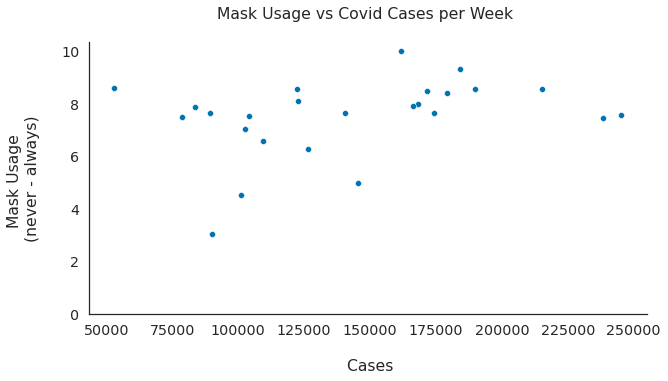

In [ ]:
#increase plot size
plt.figure(figsize=(10, 5))

#Scatter plot of covid cases vs mask use
sns.scatterplot(x='cases', y='mask', data= weekly_data)

#Set Labels
plt.title("Mask Usage vs Covid Cases per Week \n")
plt.xlabel("\n Cases")
plt.ylabel("Mask Usage \n (never - always) \n")

#Set y-axis to start at 0
plt.ylim(bottom=0)

sns.despine()

In [ ]:
#Check correlation between these data sets
stats.pearsonr(weekly_data['cases'], weekly_data['mask'])
#Not statistically significant

(0.3245226700992124, 0.11348458458118216)

###Cases v Avoiding Gatherings of 3-10 people
---
Not a statistically significant correlation

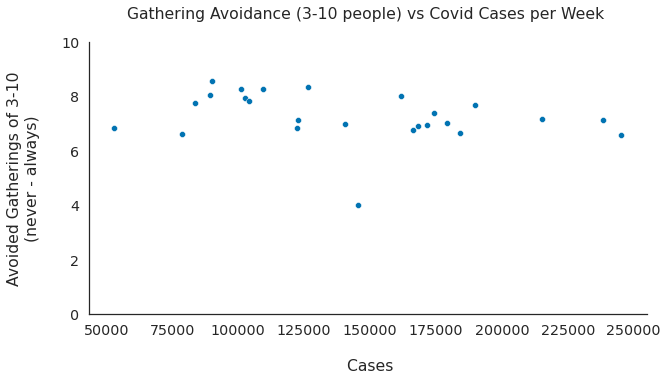

In [ ]:
#increase plot size
plt.figure(figsize=(10, 5))

#scatterplot of covid cases vs gathering of 3-10 people avoidance
sns.scatterplot(x='cases', y='avoid_gatherings_3to10', data= weekly_data)

#Set Labels
plt.title("Gathering Avoidance (3-10 people) vs Covid Cases per Week \n")
plt.xlabel("\n Cases")
plt.ylabel("Avoided Gatherings of 3-10\n (never - always) \n")

#Set y-axis to start at 0
plt.ylim(ymin=0)
plt.ylim(ymax=10)

sns.despine()

In [ ]:
#Check correlation between these data sets
stats.pearsonr(weekly_data['cases'], weekly_data['avoid_gatherings_3to10'])
#Not statistically significant

(-0.28507311211695874, 0.16720167022516702)

###Cases v Avoiding Gatherings of 10+ people
---
Not a statistically significant correlation

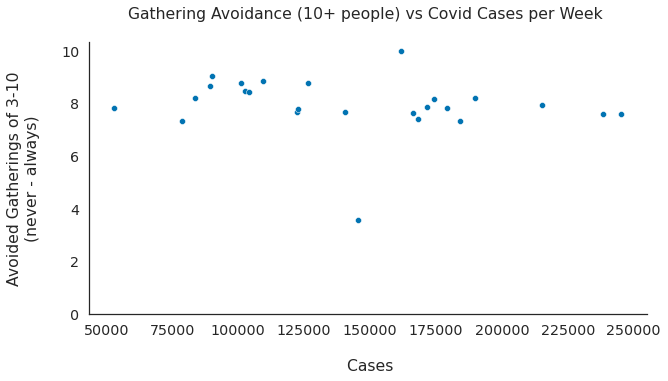

In [ ]:
#increase plot size
plt.figure(figsize=(10, 5))

#scatterplot of covid cases vs gathering of 1+0 people avoidance
sns.scatterplot(x='cases', y='avoid_gatherings_10plus', data= weekly_data)

#Set Labels
plt.title("Gathering Avoidance (10+ people) vs Covid Cases per Week \n")
plt.xlabel("\n Cases")
plt.ylabel("Avoided Gatherings of 3-10\n (never - always) \n")

#Set y-axis to start at 0
plt.ylim(ymin=0)

sns.despine()

In [ ]:
#Check correlation between these data sets
stats.pearsonr(weekly_data['cases'], weekly_data['avoid_gatherings_10plus'])
#Not statistically significant

(-0.17903983549882221, 0.3918216378311565)

### Masks v Avoiding Gatherings of 3-10 people
---
Not a statistically significant correlation

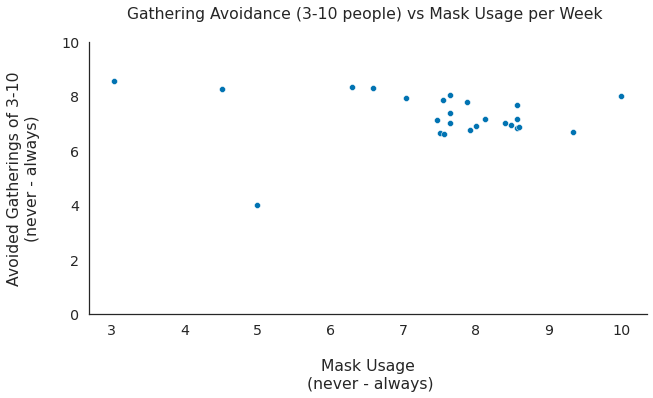

In [ ]:
#increase plot size
plt.figure(figsize=(10, 5))

#scatterplot of Mask Usage vs gathering of 3-10 people avoidance
sns.scatterplot(x='mask', y='avoid_gatherings_3to10', data= weekly_data)

#Set Labels
plt.title("Gathering Avoidance (3-10 people) vs Mask Usage per Week \n")
plt.xlabel("\n Mask Usage \n (never - always)")
plt.ylabel("Avoided Gatherings of 3-10\n (never - always) \n")

#Set y-axis to start at 0 and go through 10
plt.ylim(ymin=0)
plt.ylim(ymax=10)

sns.despine()

In [ ]:
#Check correlation between these data sets
stats.pearsonr(weekly_data['mask'], weekly_data['avoid_gatherings_3to10'])
#Not statistically significant

(-0.11374458131879504, 0.5882535173089298)

###Masks v Avoiding Gatherings of 10+ people
---
Not a statistically significant correlation

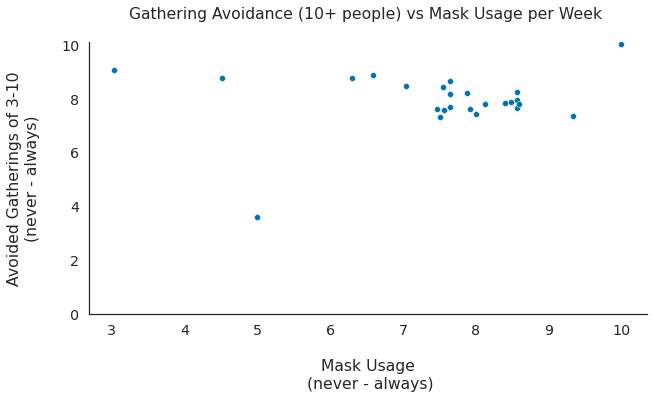

In [ ]:
#increase plot size
plt.figure(figsize=(10, 5))

#scatterplot of Mask Usage vs gathering of 10+ people avoidance
sns.scatterplot(x='mask', y='avoid_gatherings_10plus', data= weekly_data)

#Set Labels
plt.title("Gathering Avoidance (10+ people) vs Mask Usage per Week \n")
plt.xlabel("\n Mask Usage \n (never - always)")
plt.ylabel("Avoided Gatherings of 3-10\n (never - always) \n")

#Set y-axis to start at 0 and go through 10
plt.ylim(ymin=0)
plt.ylim(ymax=10.1)

sns.despine()

In [ ]:
#Check correlation between these data sets
stats.pearsonr(weekly_data['mask'], weekly_data['avoid_gatherings_10plus'])
#Not statistically significant

(0.12145546010567468, 0.5630380634109969)

###Avoiding Gatherings of 3-10 people v Avoiding gatherings of 10+ people
---
Statistically significant (p <.005) positive corration (.999)

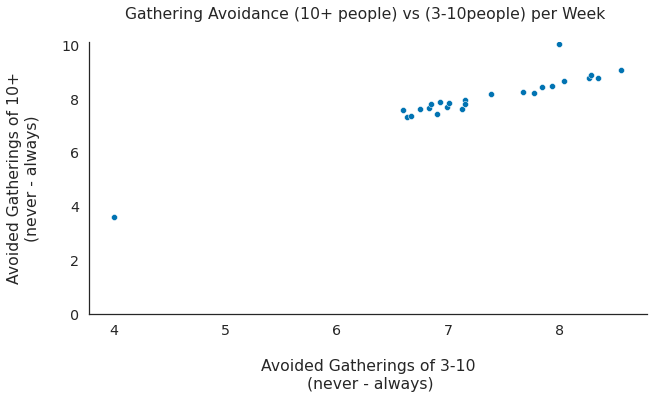

In [ ]:
#increase plot size
plt.figure(figsize=(10, 5))

#scatterplot of gathering 3-10 vs gathering of 10+ people avoidance
sns.scatterplot(x='avoid_gatherings_3to10', y='avoid_gatherings_10plus', data= weekly_data)

#Set Labels
plt.title("Gathering Avoidance (10+ people) vs (3-10people) per Week \n")
plt.xlabel("\n Avoided Gatherings of 3-10 \n (never - always)")
plt.ylabel("Avoided Gatherings of 10+\n (never - always) \n")

#Set y-axis to start at 0 and go through 10
plt.ylim(ymin=0)
plt.ylim(ymax=10.1)

sns.despine()

In [ ]:
#Check correlation between these data sets
stats.pearsonr(weekly_data['avoid_gatherings_10plus'], weekly_data['avoid_gatherings_10plus'])
#Statistically significant positive correlation

(0.9999999999999999, 1.5864253030664577e-181)

##Lineplots


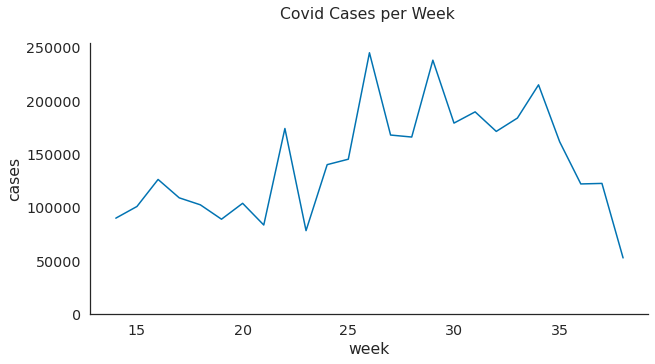

In [ ]:
#increase plot size
plt.figure(figsize=(10, 5))

#Lineplot of covid cases per week
sns.lineplot(x='week', y='cases', data= weekly_data)

#Set Labels
plt.title("Covid Cases per Week \n")

#Set y-axis to start at 0
plt.ylim(bottom=0)

sns.despine()

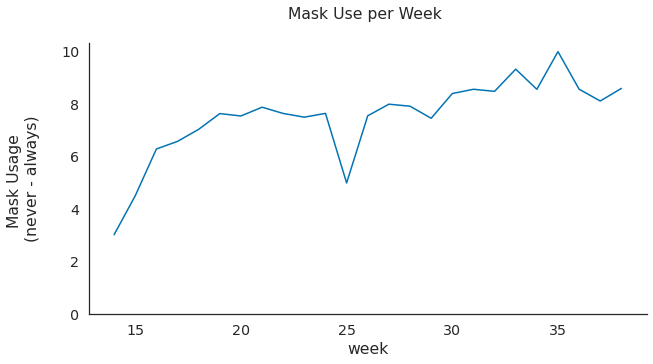

In [ ]:
#increase plot size
plt.figure(figsize=(10, 5))

#Line plot of mask usage per week
sns.lineplot(x='week', y='mask', data= weekly_data)

#Set Labels
plt.title("Mask Use per Week \n")

plt.ylabel("Mask Usage \n (never - always) \n")

#Set y-axis to start at 0
plt.ylim(bottom=0)

sns.despine()

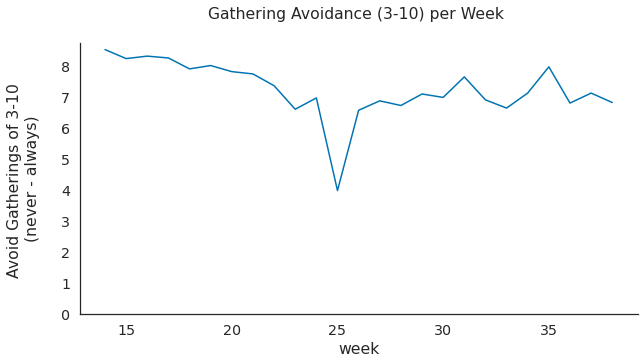

In [ ]:
#increase plot size
plt.figure(figsize=(10, 5))

#Lineplot of gathering avoidance per week
sns.lineplot(x='week', y='avoid_gatherings_3to10', data= weekly_data)

#Set Labels
plt.title("Gathering Avoidance (3-10) per Week \n")

plt.ylabel("Avoid Gatherings of 3-10 \n (never - always) \n")

#Set y-axis to start at 0
plt.ylim(bottom=0)

sns.despine()

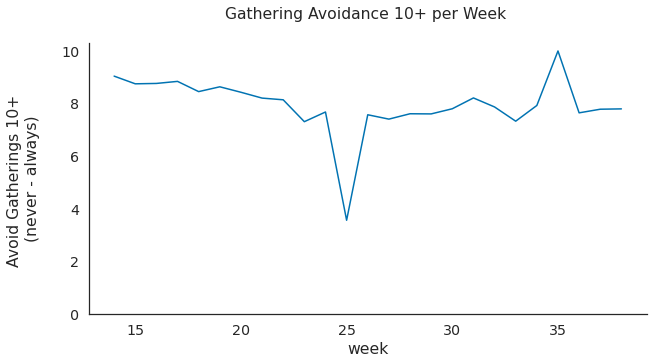

In [ ]:
#increase plot size
plt.figure(figsize=(10, 5))

#Lineplot of gathering avoidance per week
sns.lineplot(x='week', y='avoid_gatherings_10plus', data= weekly_data)

#Set Labels
plt.title("Gathering Avoidance 10+ per Week \n")

plt.ylabel("Avoid Gatherings 10+ \n (never - always) \n")

#Set y-axis to start at 0
plt.ylim(bottom=0)

sns.despine()

#Hypothesis 2: POC ethnic groups are impacted more strongly by covid-19, as measured by hospitalization, icu admission, and death rates.
---

Null: there is no statistically significant difference in covid-19 impact for POC ethnic groups

---
Blacks and Hispanics are significantly more affected by Covid-19 than Whites. 

Hypothesis supported, Null hypothesis is rejected.

---

See Markdown cells below for details on statistical significance

##Baseline % of Black, Hispanic, and White cases
---
z-test results:

The difference in frequency for black americans in the population (13.4%) and black americans with covid (19.6%) is statistically significant with p <<<0.05.

The difference in frequency for hispanic americans in the population (18.5%) and hispanic americans with covid (29.5%) is statistically significant with p <<<0.05.

The difference in frequency for white americans in the population (60.1%) and white americans with covid (41.3%) is statistically significant with p <<<0.05.


###Step 1: Find % of ethnicities of interest

In [ ]:
#Check what ethnicities are in the data
ethnicities = covid_results_df.race_ethnicity_combined.unique()

print(ethnicities)

['Multiple/Other, Non-Hispanic' 'Unknown' 'Hispanic/Latino'
 'Black, Non-Hispanic' 'White, Non-Hispanic' 'Asian, Non-Hispanic'
 'American Indian/Alaska Native, Non-Hispanic'
 'Native Hawaiian/Other Pacific Islander, Non-Hispanic']


####Create filtered df that only has rows for cases where race is known

In [ ]:
#Look at counts for cases by race
covid_results_df['race_ethnicity_combined'].value_counts()

#Select 3 values for further investigations
#'White, Non-Hispanic', 'Black, Non-Hispanic', 'Hispanic/Latino'

Unknown                                                 1564170
White, Non-Hispanic                                      861985
Hispanic/Latino                                          619282
Black, Non-Hispanic                                      411574
Multiple/Other, Non-Hispanic                             100137
Asian, Non-Hispanic                                       67270
American Indian/Alaska Native, Non-Hispanic               27276
Native Hawaiian/Other Pacific Islander, Non-Hispanic       8306
Name: race_ethnicity_combined, dtype: int64

In [ ]:
#Creating a data set that contains only rows with known racial information
covid_cases_known_race = covid_results_df

In [ ]:
#Drop 'Unknown'
covid_cases_known_race = covid_cases_known_race[covid_cases_known_race.race_ethnicity_combined != 'Unknown']

In [ ]:
#Drop 'NA'
covid_cases_known_race = covid_cases_known_race[covid_cases_known_race.race_ethnicity_combined != 'NA']

In [ ]:
#Check value counts for race
covid_cases_known_race['race_ethnicity_combined'].value_counts()

White, Non-Hispanic                                     861985
Hispanic/Latino                                         619282
Black, Non-Hispanic                                     411574
Multiple/Other, Non-Hispanic                            100137
Asian, Non-Hispanic                                      67270
American Indian/Alaska Native, Non-Hispanic              27276
Native Hawaiian/Other Pacific Islander, Non-Hispanic      8306
Name: race_ethnicity_combined, dtype: int64

####Black DF

In [ ]:
#black cases

#Create filter
filter_black_cases = covid_cases_known_race['race_ethnicity_combined'] == 'Black, Non-Hispanic'

#Check how many true and false statements are in the filter
filter_black_cases.value_counts()

False    1684256
True      411574
Name: race_ethnicity_combined, dtype: int64

In [ ]:
#Create new DF
black_covid_cases = covid_cases_known_race.iloc[filter_black_cases.values]

In [ ]:
#Check df row count
black_covid_cases.shape
#Check df rows
black_covid_cases.shape[0]

411574

####Hispanic DF

In [ ]:
#Hispanic Cases
filter_hispanic_cases = covid_cases_known_race['race_ethnicity_combined'] == 'Hispanic/Latino'

#Check how many true and false statements are in the filter
filter_hispanic_cases.value_counts()

False    1476548
True      619282
Name: race_ethnicity_combined, dtype: int64

In [ ]:
#Create new DF
hispanic_covid_cases = covid_cases_known_race.iloc[filter_hispanic_cases.values]

In [ ]:
#Check row count
hispanic_covid_cases.shape
#Check df rows
hispanic_covid_cases.shape[0]

619282

####White DF

In [ ]:
#white cases

#Create filter
filter_white_cases = covid_cases_known_race['race_ethnicity_combined'] == 'White, Non-Hispanic'

#Check how many true and false statements are in the filter
filter_white_cases.value_counts()

False    1233845
True      861985
Name: race_ethnicity_combined, dtype: int64

In [ ]:
#Create new DF
white_covid_cases = covid_cases_known_race.iloc[filter_white_cases.values]

In [ ]:
#Check the df rows
white_covid_cases.shape[0]

861985

####Create dictionary with % for each ethnicity


In [ ]:
#Create empty dictionary to store row values for later
covid_cases_dict = {}

#Fill with row count for each of the filtered tables

#Black
black_rows = black_covid_cases.shape[0]
#Add to dictionary
covid_cases_dict['Black_cases'] = black_rows

#Hispanic
hispanic_rows = hispanic_covid_cases.shape[0]
#Add to dictionary
covid_cases_dict['Hispanic_cases'] = hispanic_rows

#White
white_rows = white_covid_cases.shape[0]
#Add to dictionary
covid_cases_dict['White_cases'] = white_rows

#Create a stored value for total cases as well
total_rows = covid_cases_known_race.shape[0]

In [ ]:
#Check dictionary
covid_cases_dict

{'Black_cases': 411574, 'Hispanic_cases': 619282, 'White_cases': 861985}

In [ ]:
#Create dictionary of the frequency of covid cases by race
ethn_percent_cases = {}

#Black percent
ethn_percent_cases['percent_black'] = round((black_rows/total_rows), 5)

#Hispanic Percent
ethn_percent_cases['percent_hispanic'] = round((hispanic_rows/total_rows), 5)

#White percent
ethn_percent_cases['percent_white'] = round((white_rows/total_rows), 5)

In [ ]:
ethn_percent_cases

{'percent_black': 0.19638,
 'percent_hispanic': 0.29548,
 'percent_white': 0.41129}

###Step 2:  z-test to compare to USA population as a whole

####Prep values for z-test

In [ ]:
#Isolate percent values from dfs and dictionaries
p_black_cases = ethn_percent_cases.get('percent_black')
p_black_pop = census_race_bhw.iloc[0]['pop_dec']

p_hispanic_cases = ethn_percent_cases.get('percent_hispanic')
p_hispanic_pop = census_race_bhw.iloc[1]['pop_dec']

p_white_cases = ethn_percent_cases.get('percent_white')
p_white_pop = census_race_bhw.iloc[2]['pop_dec']

In [ ]:
#Isolate counts from dfs and dictionaries
c_black_cases = black_rows
c_black_pop = census_race_bhw.iloc[0]['pop_count']

c_hispanic_cases = hispanic_rows
c_hispanic_pop = census_race_bhw.iloc[1]['pop_count']

c_white_cases = white_rows
c_white_pop = census_race_bhw.iloc[2]['pop_count']

####Build function to perform z-test

In [ ]:
#Build a function to calculate z test and store values in a dictionary for later reference
def z_test(c_count, v_count, c_freq, v_freq, dictionary):
  proportion_diff = v_freq - c_freq
  pooled_samp_prop = (((c_count * c_freq)+(v_count * v_freq))/(c_count + v_count))
  std_err_diff = np.sqrt(((c_freq*(1-c_freq))/c_count)+((v_freq*(1-v_freq))/v_count))
  control_err = np.sqrt((c_freq*(1-c_freq))/c_count) #std err of proportion 
  dictionary['err_c'] = round(control_err, 3) #Store in dict
  variable_err = np.sqrt((v_freq*(1-v_freq))/v_count)# std err of proportion
  dictionary['err_v'] = round(variable_err, 3) #Store in dict
  z_stat = proportion_diff/std_err_diff
  dictionary['z_stat'] = round(z_stat, 3) #Store in dict
  pval = 2*(norm.sf(abs(z_stat)))
  dictionary['pval'] = round(pval, 4) #Store in dict  
  conf_int = (std_err_diff * 1.96)
  dictionary['conf_int'] = round(conf_int, 3) #Store in dict
  lower_lim = (proportion_diff - conf_int)
  dictionary['lim_lower'] = round(lower_lim, 3) #Store in dict
  upper_lim = (proportion_diff + conf_int)
  dictionary['lim_upper'] = round(upper_lim, 3) #Store in dict
  return dictionary

#####Test function pieces
keeping here to show thought process, this cell isn't needed anymore

In [ ]:
#Test function pieces here

#prop diff
bt_prop_diff = p_black_cases - p_black_pop
#bt_prop_diff

# psp
bt_pool_samp_prop = (((c_black_pop * p_black_pop)+(c_black_cases*p_black_cases))/(c_black_pop+c_black_cases))
#bt_pool_samp_prop

#std err diff
bt_std_e_diff = np.sqrt(((p_black_pop*(1-p_black_pop))/c_black_pop)+((p_black_cases*(1-p_black_cases))/c_black_cases))
#bt_std_e_diff

#zstat
bt_zstat = bt_prop_diff/bt_std_e_diff
#bt_zstat

#pval
bt_pval = 2*(norm.sf(abs(bt_zstat)))
#bt_pval

#Confidence interval
bt_ci = (bt_std_e_diff*1.96)
#bt_ci

#Lower Lim
bt_llim = (bt_prop_diff - bt_ci)
#bt_llim

#upper lim
bt_ulim = (bt_prop_diff + bt_ci)
#bt_ulim

####Perform z-tests



In [ ]:
#Black cases z-test

#Define dictionary
z_test_black_results = {}

#Call function
z_test(c_black_pop, c_black_cases, p_black_pop, p_black_cases, z_test_black_results)

{'conf_int': 0.001,
 'err_c': 0.0,
 'err_v': 0.001,
 'lim_lower': 0.061,
 'lim_upper': 0.064,
 'pval': 0.0,
 'z_stat': 100.735}

In [ ]:
#Hispanic cases z-test

#Define dictionary
z_test_hispanic_results = {}

#Call function
z_test(c_hispanic_pop, c_hispanic_cases, p_hispanic_pop, p_hispanic_cases, z_test_hispanic_results)

{'conf_int': 0.001,
 'err_c': 0.0,
 'err_v': 0.001,
 'lim_lower': 0.109,
 'lim_upper': 0.112,
 'pval': 0.0,
 'z_stat': 190.547}

In [ ]:
#White cases z-test

#Define dictionary
z_test_white_results = {}

#Call function
z_test(c_white_pop, c_white_cases, p_white_pop, p_white_cases, z_test_white_results)

{'conf_int': 0.001,
 'err_c': 0.0,
 'err_v': 0.001,
 'lim_lower': -0.191,
 'lim_upper': -0.189,
 'pval': 0.0,
 'z_stat': -357.936}

##Hospitalization % of Black, Hispanic, and White cases
---
z-test results:

The difference in frequency for black americans with covid (19.6%) and black americans with covid admitted to the hospital (25.81%) is statistically significant with p <<<0.05.

The difference in frequency for hispanic americans with covid (29.5) and hispanic americans with covid admitted to the hospital (26.14%) is statistically significant with p <<<0.05.

The difference in frequency for white americans with covid (41.3) and white americans with covid admitted to the hospital (37.29%) is statistically significant with p <<<0.05.

###Step 1 look at individual races and the hospitalization % of cases

####Create initial data frame
Create a new starting df here, that will allow me to mostly reuse code from above

In [ ]:
#Identify unique values and counts for hospitalization
covid_cases_known_race.hosp_yn.value_counts()

No         1166699
Missing     497862
Yes         236457
Unknown     194812
Name: hosp_yn, dtype: int64

In [ ]:
#Again, keep only data where we know the result, Y/N in this case

#Drop 'Unknown'
covid_hosp_known_u = covid_cases_known_race[covid_cases_known_race.hosp_yn != 'Unknown']

In [ ]:
#Drop 'Missing'
covid_hosp_known = covid_hosp_known_u[covid_hosp_known_u.hosp_yn != 'Missing']

In [ ]:
#Check values have been droped
covid_hosp_known.hosp_yn.value_counts()

No     1166699
Yes     236457
Name: hosp_yn, dtype: int64

In [ ]:
#store relative frequency in a dictionary in case I want it later
percent_hosp = covid_hosp_known.hosp_yn.value_counts(normalize= True).to_dict()

####Black DF

In [ ]:
#Create filter
filter_black_hosp = covid_hosp_known['race_ethnicity_combined'] == 'Black, Non-Hispanic'

#Check how many true and false statements are in the filter
filter_black_hosp.value_counts()

False    1138051
True      265105
Name: race_ethnicity_combined, dtype: int64

In [ ]:
#Create new DF with known race and hospitalization values
black_hosp = covid_hosp_known.iloc[filter_black_hosp.values]

In [ ]:
#Check the df rows
black_hosp.shape[0]

265105

####Hispanic DF

In [ ]:
#Create filter
filter_hispanic_hosp = covid_hosp_known['race_ethnicity_combined'] == 'Hispanic/Latino'

#Check how many true and false statements are in the filter
filter_hispanic_hosp.value_counts()

False    996998
True     406158
Name: race_ethnicity_combined, dtype: int64

In [ ]:
#Create new DF with known race and hospitalization values
hispanic_hosp = covid_hosp_known.iloc[filter_hispanic_hosp.values]

In [ ]:
#Check the df rows
hispanic_hosp.shape[0]

406158

####White DF

In [ ]:
#Create filter
filter_white_hosp = covid_hosp_known['race_ethnicity_combined'] == 'White, Non-Hispanic'

#Check how many true and false statements are in the filter
filter_white_hosp.value_counts()

False    797116
True     606040
Name: race_ethnicity_combined, dtype: int64

In [ ]:
#Create new DF with known race and hospitalization values
white_hosp = covid_hosp_known.iloc[filter_white_hosp.values]

In [ ]:
#Check the df rows
white_hosp.shape[0]

606040

####Create dictionary for % yes of each ethnicity



In [ ]:
#Create empty dictionary to store total row values for later
covid_hosp_total = {}

#Fill with row count for each of the filtered tables

#total Black rows
black_rows_hosp_t = black_hosp.shape[0]
#Add to dictionary
covid_hosp_total['Black_hosp'] = black_rows_hosp_t

#Hispanic
hispanic_rows_hosp_t = hispanic_hosp.shape[0]
#Add to dictionary
covid_hosp_total['Hispanic_hosp'] = hispanic_rows_hosp_t

#White
white_rows_hosp_t = white_hosp.shape[0]
#Add to dictionary
covid_hosp_total['White_hosp'] = white_rows_hosp_t

#Create a stored value for total cases as well
covid_hosp_total['Total_hosp'] = covid_hosp_known.shape[0]

#Check Dictionary
covid_hosp_total

{'Black_hosp': 265105,
 'Hispanic_hosp': 406158,
 'Total_hosp': 1403156,
 'White_hosp': 606040}

In [ ]:
#Create dictionary of Yes row values fore later
covid_hosp_yes = {}

##Black
#Utilize value_counts.to_list to harvest the number of Yes rows in the df
black_rows_hosp_yn = (black_hosp.hosp_yn == 'Yes').value_counts().tolist()
#Store Y values
black_rows_hosp_y = black_rows_hosp_yn[1]
#Add to dictionary
covid_hosp_yes['black_hosp_y'] = black_rows_hosp_y

##Hispanic
#Utilize value_counts.to_list to harvest the number of Yes rows in the df
hispanic_rows_hosp_yn = (hispanic_hosp.hosp_yn == 'Yes').value_counts().tolist()
#Store Y values
hispanic_rows_hosp_y = hispanic_rows_hosp_yn[1]
#Add to dictionary
covid_hosp_yes['hispanic_hosp_y'] = hispanic_rows_hosp_y

##White
#Utilize value_counts.to_list to harvest the number of Yes rows in the df
white_rows_hosp_yn = (white_hosp.hosp_yn == 'Yes').value_counts().tolist()
#Store Y values
white_rows_hosp_y = white_rows_hosp_yn[1]
#Add to dictionary
covid_hosp_yes['white_hosp_y'] = white_rows_hosp_y

##Total
#Utilize value_counts.to_list to harvest the number of Yes rows in the df
total_rows_hosp_yn = (covid_hosp_known.hosp_yn == 'Yes').value_counts().tolist()
#Store Y values
total_rows_hosp_y = total_rows_hosp_yn[1]
#Add to dictionary
covid_hosp_yes['total_hosp_y'] = total_rows_hosp_y


covid_hosp_yes

{'black_hosp_y': 61034,
 'hispanic_hosp_y': 61821,
 'total_hosp_y': 236457,
 'white_hosp_y': 88176}

In [ ]:
#Create dictionary 
hosp_percent_cases = {}

#Black percent
hosp_percent_cases['p_black_hosp'] = round((black_rows_hosp_y/total_rows_hosp_y), 5)

#Hispanic Percent
hosp_percent_cases['p_hispanic_hosp'] = round((hispanic_rows_hosp_y/total_rows_hosp_y), 5)

#White percent
hosp_percent_cases['p_white_hosp'] = round((white_rows_hosp_y/total_rows_hosp_y), 5)

#Check dictionary
hosp_percent_cases

{'p_black_hosp': 0.25812, 'p_hispanic_hosp': 0.26145, 'p_white_hosp': 0.37291}

###Step 2:  z-test to compare hospitalization frequency with covid frequency

####Prep values for z-test

In [ ]:
#Isolate percent values from dfs and dictionaries
p_black_hosp = hosp_percent_cases.get('p_black_hosp')

p_hispanic_hosp = hosp_percent_cases.get('p_hispanic_hosp')

p_white_hosp = hosp_percent_cases.get('p_white_hosp')

In [ ]:
#Isolate counts from dfs and dictionaries
c_black_hosp = covid_hosp_yes.get('black_hosp_y')

c_hispanic_hosp = covid_hosp_yes.get('hispanic_hosp_y')

c_white_hosp = covid_hosp_yes.get('white_hosp_y')

#####Perform z-tests

In [ ]:
#Black cases z-test

#Define dictionary
z_test_black_hosp = {}

#Call function
z_test(c_black_cases, c_black_hosp, p_black_cases, p_black_hosp, z_test_black_hosp)

{'conf_int': 0.004,
 'err_c': 0.001,
 'err_v': 0.002,
 'lim_lower': 0.058,
 'lim_upper': 0.065,
 'pval': 0.0,
 'z_stat': 32.903}

In [ ]:
#HIspanic cases z-test

#Define dictionary
z_test_hispanic_hosp = {}

#Call function
z_test(c_hispanic_cases, c_hispanic_hosp, p_hispanic_cases, p_hispanic_hosp, z_test_hispanic_hosp)

{'conf_int': 0.004,
 'err_c': 0.001,
 'err_v': 0.002,
 'lim_lower': -0.038,
 'lim_upper': -0.03,
 'pval': 0.0,
 'z_stat': -18.296}

In [ ]:
#White cases z-test

#Define dictionary
z_test_white_hosp = {}

#Call function
z_test(c_white_cases, c_white_hosp, p_white_cases, p_white_hosp, z_test_white_hosp)

{'conf_int': 0.003,
 'err_c': 0.001,
 'err_v': 0.002,
 'lim_lower': -0.042,
 'lim_upper': -0.035,
 'pval': 0.0,
 'z_stat': -22.411}

##ICU % of Black, Hispanic, and White cases
---
z-test results icu vs cases:

The difference in frequency for black americans with covid (19.6%) and black americans with covid admitted to the icu (25.01%) is statistically significant with p <<<0.05.

The difference in frequency for hispanic americans with covid (29.5) and hispanic americans with covid admitted to the icu (25.24%) is statistically significant with p <<<0.05.

The difference in frequency for white americans with covid (41.3) and white americans with covid admitted to the icu (37.49%) is statistically significant with p <<<0.05.

---

z-test results icu vs hosp (not significant):

The difference in frequency for black americans with covid admitted to the hospital (25.81%) and black americans with covid admitted to the icu (25.01%) is not statistically significant with p = 0.119.

The difference in frequency for hispanic americans with covid admitted to the hospital (26.14%) and hispanic americans with covid admitted to the icu (25.24%) is not statistically significant with p = 0.077.

The difference in frequency for white americans with covid admitted to the hospital (37.29%) and white americans with covid admitted to the icu (37.49%) is not statistically significant with p = 0.666.

###Step 1: look at individual races and the ICU % of cases
Of those hospitalized, how many ended up in the ICU?

####Create initial data frame
Create a new starting df here, that will allow me to mostly reuse code from above

In [ ]:
#Use dataframe with hosp known for further filtering so that I don't 
#introduce error due to sampling more rows than before

#Identify unique values and counts for ICU
covid_hosp_known.icu_yn.value_counts()

Missing    829339
No         301761
Unknown    239904
Yes         32152
Name: icu_yn, dtype: int64

In [ ]:
#Again, keep only data where we know the result, Y/N in this case

#Drop 'Unknown'
covid_icu_known_u = covid_hosp_known[covid_hosp_known.icu_yn != 'Unknown']

In [ ]:
#Drop 'Missing'
covid_icu_known = covid_icu_known_u[covid_icu_known_u.icu_yn != 'Missing']

In [ ]:
#Check that I dropped the rows
covid_icu_known.icu_yn.value_counts()

No     301761
Yes     32152
Name: icu_yn, dtype: int64

####Black DF

In [ ]:
#Create filter
filter_black_icu = covid_icu_known['race_ethnicity_combined'] == 'Black, Non-Hispanic'

#Check how many true and false statements are in the filter
filter_black_icu.value_counts()

False    280563
True      53350
Name: race_ethnicity_combined, dtype: int64

In [ ]:
#Create new DF with known race and hospitalization values
black_icu = covid_icu_known.iloc[filter_black_icu.values]

In [ ]:
#Check the df rows
black_icu.shape[0]

53350

####Hispanic DF

In [ ]:
#Create filter
filter_hispanic_icu = covid_icu_known['race_ethnicity_combined'] == 'Hispanic/Latino'

#Check how many true and false statements are in the filter
filter_hispanic_icu.value_counts()

False    243434
True      90479
Name: race_ethnicity_combined, dtype: int64

In [ ]:
#Create new DF with known race and hospitalization values
hispanic_icu = covid_icu_known.iloc[filter_hispanic_icu.values]

In [ ]:
#Check the df rows
hispanic_icu.shape[0]

90479

####White DF

In [ ]:
#Create filter
filter_white_icu = covid_icu_known['race_ethnicity_combined'] == 'White, Non-Hispanic'

#Check how many true and false statements are in the filter
filter_white_icu.value_counts()

False    170997
True     162916
Name: race_ethnicity_combined, dtype: int64

In [ ]:
#Create new DF with known race and hospitalization values
white_icu = covid_icu_known.iloc[filter_white_icu.values]

In [ ]:
#Check the df rows
white_icu.shape[0]

162916

####Create dictionary for % yes of each ethnicity



In [ ]:
#Create empty dictionary to store total row values for later
covid_icu_total = {}

#Fill with row count for each of the filtered tables

#total Black rows
black_rows_icu_t = black_icu.shape[0]
#Add to dictionary
covid_icu_total['Black_icu'] = black_rows_icu_t

#Hispanic
hispanic_rows_icu_t = hispanic_icu.shape[0]
#Add to dictionary
covid_icu_total['Hispanic_icu'] = hispanic_rows_icu_t

#White
white_rows_icu_t = white_icu.shape[0]
#Add to dictionary
covid_icu_total['White_icu'] = white_rows_icu_t

#Create a stored value for total cases as well
covid_icu_total['Total_icu'] = covid_icu_known.shape[0]

#Check Dictionary
covid_icu_total

{'Black_icu': 53350,
 'Hispanic_icu': 90479,
 'Total_icu': 333913,
 'White_icu': 162916}

In [ ]:
#Create dictionary of Yes row values in case I want it later, don't *need* at this step
covid_icu_yes = {}

##Black
#Utilize value_counts.to_list to harvest the number of Yes rows in the df
black_rows_icu_yn = (black_icu.icu_yn == 'Yes').value_counts().tolist()
#Store Y values
black_rows_icu_y = black_rows_icu_yn[1]
#Add to dictionary
covid_icu_yes['black_icu_y'] = black_rows_icu_y

##Hispanic
#Utilize value_counts.to_list to harvest the number of Yes rows in the df
hispanic_rows_icu_yn = (hispanic_icu.icu_yn == 'Yes').value_counts().tolist()
#Store Y values
hispanic_rows_icu_y = hispanic_rows_icu_yn[1]
#Add to dictionary
covid_icu_yes['hispanic_icu_y'] = hispanic_rows_icu_y

##White
#Utilize value_counts.to_list to harvest the number of Yes rows in the df
white_rows_icu_yn = (white_icu.icu_yn == 'Yes').value_counts().tolist()
#Store Y values
white_rows_icu_y = white_rows_icu_yn[1]
#Add to dictionary
covid_icu_yes['white_icu_y'] = white_rows_icu_y

##Total
#Utilize value_counts.to_list to harvest the number of Yes rows in the df
total_rows_icu_yn = (covid_icu_known.icu_yn == 'Yes').value_counts().tolist()
#Store Y values
total_rows_icu_y = total_rows_icu_yn[1]
#Add to dictionary
covid_icu_yes['total_icu_y'] = total_rows_icu_y


covid_icu_yes

{'black_icu_y': 8041,
 'hispanic_icu_y': 8114,
 'total_icu_y': 32152,
 'white_icu_y': 12055}

In [ ]:
#Create dictionary 
icu_percent_cases = {}

#Black percent
icu_percent_cases['p_black_icu'] = round((black_rows_icu_y/total_rows_icu_y), 5)

#Hispanic Percent
icu_percent_cases['p_hispanic_icu'] = round((hispanic_rows_icu_y/total_rows_icu_y), 5)

#White percent
icu_percent_cases['p_white_icu'] = round((white_rows_icu_y/total_rows_icu_y), 5)

#Check dictionary
icu_percent_cases

{'p_black_icu': 0.25009, 'p_hispanic_icu': 0.25236, 'p_white_icu': 0.37494}

###Step 2.a: z-test icu vs cases

####Prep values for z-tests

In [ ]:
#Isolate frequency values from dfs and dictionaries
p_black_icu = icu_percent_cases.get('p_black_icu')

p_hispanic_icu = icu_percent_cases.get('p_hispanic_icu')

p_white_icu = icu_percent_cases.get('p_white_icu')

In [ ]:
#Isolate counts from dfs and dictionaries
c_black_icu = covid_icu_yes.get('black_icu_y')

c_hispanic_icu = covid_icu_yes.get('hispanic_icu_y')

c_white_icu = covid_icu_yes.get('white_icu_y')

#####Perform z-tests

In [ ]:
#Black cases z-test

#Define dictionary
z_test_black_icu_v_cases = {}

#Call function
z_test(c_black_cases, c_black_icu, p_black_cases, p_black_icu, z_test_black_icu_v_cases)

{'conf_int': 0.01,
 'err_c': 0.001,
 'err_v': 0.005,
 'lim_lower': 0.044,
 'lim_upper': 0.063,
 'pval': 0.0,
 'z_stat': 11.031}

In [ ]:
#HIspanic cases z-test

#Define dictionary
z_test_hispanic_icu_v_cases = {}

#Call function
z_test(c_hispanic_cases, c_hispanic_icu, p_hispanic_cases, p_hispanic_icu, z_test_hispanic_icu_v_cases)

{'conf_int': 0.01,
 'err_c': 0.001,
 'err_v': 0.005,
 'lim_lower': -0.053,
 'lim_upper': -0.034,
 'pval': 0.0,
 'z_stat': -8.878}

In [ ]:
#White cases z-test

#Define dictionary
z_test_white_icu_v_cases = {}

#Call function
z_test(c_white_cases, c_white_icu, p_white_cases, p_white_icu, z_test_white_icu_v_cases)

{'conf_int': 0.009,
 'err_c': 0.001,
 'err_v': 0.004,
 'lim_lower': -0.045,
 'lim_upper': -0.028,
 'pval': 0.0,
 'z_stat': -8.185}

###Step 2.b: z-test icu vs hospitalizations


#####Perform z-tests

In [ ]:
#Black cases z-test

#Define dictionary
z_test_black_icu_v_hosp = {}

#Call function
z_test(c_black_hosp, c_black_icu, p_black_hosp, p_black_icu, z_test_black_icu_v_cases)

{'conf_int': 0.01,
 'err_c': 0.002,
 'err_v': 0.005,
 'lim_lower': -0.018,
 'lim_upper': 0.002,
 'pval': 0.1185,
 'z_stat': -1.561}

In [ ]:
#Hispanic cases z-test

#Define dictionary
z_test_hispanic_icu_v_cases = {}

#Call function
z_test(c_hispanic_hosp, c_hispanic_icu, p_hispanic_hosp, p_hispanic_icu, z_test_hispanic_icu_v_cases)

{'conf_int': 0.01,
 'err_c': 0.002,
 'err_v': 0.005,
 'lim_lower': -0.019,
 'lim_upper': 0.001,
 'pval': 0.0767,
 'z_stat': -1.77}

In [ ]:
#White cases z-test

#Define dictionary
z_test_white_icu_v_cases = {}

#Call function
z_test(c_white_hosp, c_white_icu, p_white_hosp, p_white_icu, z_test_white_icu_v_cases)

{'conf_int': 0.009,
 'err_c': 0.002,
 'err_v': 0.004,
 'lim_lower': -0.007,
 'lim_upper': 0.011,
 'pval': 0.6658,
 'z_stat': 0.432}

##Death % of Black, Hispanic, and White cases
---

The difference in frequency for death vs total cases, death vs hospitalizations, and death vs icu admissions are statistically significant with p <<<0.05 for all values.

Black: 22.64% death vs 25.01% icu, 25.81% hosp, & 19.6% cases

Hispanic: 20.21% death vs 25.24% icu, 26.14% hosp, & 29.5% cases

White: 46.38% deaths vs 37.49% icu, 37.29% hosp, & 41.3% cases

###Step 1 look at individual races and the Death % of cases

---


Of those where race, hospitalization, and icu info is known, how many died

####Create initial data frame
Create a new starting df here, that will allow me to mostly reuse code from above

In [ ]:
#Use dataframe with icu known for further filtering so that I don't 
#introduce error due to sampling more rows than before

#Identify unique values and counts for death
covid_icu_known.death_yn.value_counts()

No         240785
Unknown     57640
Yes         20713
Missing     14775
Name: death_yn, dtype: int64

In [ ]:
#Again, keep only data where we know the result, Y/N in this case

#Drop 'Unknown'
covid_death_known_u = covid_icu_known[covid_icu_known.death_yn != 'Unknown']

In [ ]:
#Drop 'Missing'
covid_death_known = covid_death_known_u[covid_death_known_u.icu_yn != 'Missing']

In [ ]:
#Check that I dropped the rows
covid_death_known.icu_yn.value_counts()

No     250189
Yes     26084
Name: icu_yn, dtype: int64

####Black DF

In [ ]:
#Create filter
filter_black_death = covid_death_known['race_ethnicity_combined'] == 'Black, Non-Hispanic'

#Check how many true and false statements are in the filter
filter_black_death.value_counts()

False    233458
True      42815
Name: race_ethnicity_combined, dtype: int64

In [ ]:
#Create new DF with known race and hospitalization values
black_death = covid_death_known.iloc[filter_black_death.values]

In [ ]:
#Check the df rows
black_death.shape[0]

42815

####Hispanic DF

In [ ]:
#Create filter
filter_hispanic_death = covid_death_known['race_ethnicity_combined'] == 'Hispanic/Latino'

#Check how many true and false statements are in the filter
filter_hispanic_death.value_counts()

False    205316
True      70957
Name: race_ethnicity_combined, dtype: int64

In [ ]:
#Create new DF with known race and hospitalization values
hispanic_death = covid_death_known.iloc[filter_hispanic_death.values]

In [ ]:
#Check the df rows
hispanic_death.shape[0]

70957

####White DF

In [ ]:
#Create filter
filter_white_death = covid_death_known['race_ethnicity_combined'] == 'White, Non-Hispanic'

#Check how many true and false statements are in the filter
filter_white_death.value_counts()

True     140146
False    136127
Name: race_ethnicity_combined, dtype: int64

In [ ]:
#Create new DF with known race and hospitalization values
white_death = covid_death_known.iloc[filter_white_death.values]

In [ ]:
#Check the df rows
white_death.shape[0]

140146

####Create dictionary for % yes of each ethnicity



In [ ]:
#Create empty dictionary to store total row values for later
covid_death_total = {}

#Fill with row count for each of the filtered tables

#total Black rows
black_rows_death_t = black_death.shape[0]
#Add to dictionary
covid_death_total['Black_death'] = black_rows_death_t

#Hispanic
hispanic_rows_death_t = hispanic_death.shape[0]
#Add to dictionary
covid_death_total['Hispanic_death'] = hispanic_rows_death_t

#White
white_rows_death_t = white_death.shape[0]
#Add to dictionary
covid_death_total['White_death'] = white_rows_death_t

#Create a stored value for total cases as well
covid_death_total['Total_death'] = covid_death_known.shape[0]

#Check Dictionary
covid_death_total

{'Black_death': 42815,
 'Hispanic_death': 70957,
 'Total_death': 276273,
 'White_death': 140146}

In [ ]:
#Create dictionary of Yes row values in case I want it later, don't *need* at this step
covid_death_yes = {}

##Black
#Utilize value_counts.to_list to harvest the number of Yes rows in the df
black_rows_death_yn = (black_death.death_yn == 'Yes').value_counts().tolist()
#Store Y values
black_rows_death_y = black_rows_death_yn[1]
#Add to dictionary
covid_death_yes['black_death_y'] = black_rows_death_y

##Hispanic
#Utilize value_counts.to_list to harvest the number of Yes rows in the df
hispanic_rows_death_yn = (hispanic_death.death_yn == 'Yes').value_counts().tolist()
#Store Y values
hispanic_rows_death_y = hispanic_rows_death_yn[1]
#Add to dictionary
covid_death_yes['hispanic_death_y'] = hispanic_rows_death_y

##White
#Utilize value_counts.to_list to harvest the number of Yes rows in the df
white_rows_death_yn = (white_death.death_yn == 'Yes').value_counts().tolist()
#Store Y values
white_rows_death_y = white_rows_death_yn[1]
#Add to dictionary
covid_death_yes['white_death_y'] = white_rows_death_y

##Total
#Utilize value_counts.to_list to harvest the number of Yes rows in the df
total_rows_death_yn = (covid_death_known.death_yn == 'Yes').value_counts().tolist()
#Store Y values
total_rows_death_y = total_rows_death_yn[1]
#Add to dictionary
covid_death_yes['total_death_y'] = total_rows_death_y


covid_death_yes

{'black_death_y': 4689,
 'hispanic_death_y': 4186,
 'total_death_y': 20713,
 'white_death_y': 9607}

In [ ]:
#Create dictionary 
death_percent_cases = {}

#Black percent
death_percent_cases['p_black_death'] = round((black_rows_death_y/total_rows_death_y), 5)

#Hispanic Percent
death_percent_cases['p_hispanic_death'] = round((hispanic_rows_death_y/total_rows_death_y), 5)

#White percent
death_percent_cases['p_white_death'] = round((white_rows_death_y/total_rows_death_y), 5)

#Check dictionary
death_percent_cases

{'p_black_death': 0.22638,
 'p_hispanic_death': 0.2021,
 'p_white_death': 0.46381}

###Step 2a: z-test deaths vs **cases**

####Prep values for z-tests

In [ ]:
#Isolate frequency values from dfs and dictionaries
p_black_death = death_percent_cases.get('p_black_death')

p_hispanic_death = death_percent_cases.get('p_hispanic_death')

p_white_death = death_percent_cases.get('p_white_death')

In [ ]:
#Isolate counts from dfs and dictionaries
c_black_death = covid_death_yes.get('black_death_y')

c_hispanic_death = covid_death_yes.get('hispanic_death_y')

c_white_death = covid_death_yes.get('white_death_y')

####Perform z-tests

In [ ]:
#Black cases z-test

#Define dictionary
z_test_black_death = {}

#Call function
z_test(c_black_cases, c_black_death, p_black_cases, p_black_death, z_test_black_death)

{'conf_int': 0.012,
 'err_c': 0.001,
 'err_v': 0.006,
 'lim_lower': 0.018,
 'lim_upper': 0.042,
 'pval': 0.0,
 'z_stat': 4.884}

In [ ]:
#Hispanic cases z-test

#Define dictionary
z_test_hispanic_death = {}

#Call function
z_test(c_hispanic_cases, c_hispanic_death, p_hispanic_cases, p_hispanic_death, z_test_hispanic_death)

{'conf_int': 0.012,
 'err_c': 0.001,
 'err_v': 0.006,
 'lim_lower': -0.106,
 'lim_upper': -0.081,
 'pval': 0.0,
 'z_stat': -14.98}

In [ ]:
#White cases z-test

#Define dictionary
z_test_white_death = {}

#Call function
z_test(c_white_cases, c_white_death, p_white_cases, p_white_death, z_test_white_death)

{'conf_int': 0.01,
 'err_c': 0.001,
 'err_v': 0.005,
 'lim_lower': 0.042,
 'lim_upper': 0.063,
 'pval': 0.0,
 'z_stat': 10.267}

###Step 2b: z-test deaths vs hospitalizations

####Perform z-tests

In [ ]:
#Black cases z-test

#Define dictionary
z_test_black_death_v_hosp = {}

#Call function
z_test(c_black_hosp, c_black_death, p_black_hosp, p_black_death, z_test_black_death_v_hosp)

{'conf_int': 0.012,
 'err_c': 0.002,
 'err_v': 0.006,
 'lim_lower': -0.044,
 'lim_upper': -0.019,
 'pval': 0.0,
 'z_stat': -4.988}

In [ ]:
#Hispanic cases z-test

#Define dictionary
z_test_hispanic_death_v_hosp = {}

#Call function
z_test(c_hispanic_hosp, c_hispanic_death, p_hispanic_hosp, p_hispanic_death, z_test_hispanic_death_v_hosp)

{'conf_int': 0.013,
 'err_c': 0.002,
 'err_v': 0.006,
 'lim_lower': -0.072,
 'lim_upper': -0.047,
 'pval': 0.0,
 'z_stat': -9.197}

In [ ]:
#White cases z-test

#Define dictionary
z_test_white_death_v_hosp = {}

#Call function
z_test(c_white_hosp, c_white_death, p_white_hosp, p_white_death, z_test_white_death_v_hosp)

{'conf_int': 0.01,
 'err_c': 0.002,
 'err_v': 0.005,
 'lim_lower': 0.08,
 'lim_upper': 0.101,
 'pval': 0.0,
 'z_stat': 17.016}

###Step 2c: z-test deaths vs icu admissions

####Perform z-tests

In [ ]:
#Black cases z-test

#Define dictionary
z_test_black_death_v_icu = {}

#Call function
z_test(c_black_icu, c_black_death, p_black_icu, p_black_death, z_test_black_death_v_icu)

{'conf_int': 0.015,
 'err_c': 0.005,
 'err_v': 0.006,
 'lim_lower': -0.039,
 'lim_upper': -0.008,
 'pval': 0.0023,
 'z_stat': -3.044}

In [ ]:
#Hispanic cases z-test

#Define dictionary
z_test_hispanic_death_v_icu = {}

#Call function
z_test(c_hispanic_icu, c_hispanic_death, p_hispanic_icu, p_hispanic_death, z_test_hispanic_death_v_icu)

{'conf_int': 0.015,
 'err_c': 0.005,
 'err_v': 0.006,
 'lim_lower': -0.066,
 'lim_upper': -0.035,
 'pval': 0.0,
 'z_stat': -6.395}

In [ ]:
#White cases z-test

#Define dictionary
z_test_white_death_v_icu = {}

#Call function
z_test(c_white_icu, c_white_death, p_white_icu, p_white_death, z_test_white_death_v_icu)

{'conf_int': 0.013,
 'err_c': 0.004,
 'err_v': 0.005,
 'lim_lower': 0.076,
 'lim_upper': 0.102,
 'pval': 0.0,
 'z_stat': 13.2}

#Hypothesis 2: Visualizations
---
See Markdown cells below for insights into visualization process

## Create dataframe from earlier outputs for use with visualizations

In [ ]:
# create an empty df so I can store frequency values from previous calculations
racial_freq = pd.DataFrame()

#Create list from df for us_pop frequencies
us_pop = census_race_bhw['pop_dec'].tolist()

#import list into df and set index
racial_freq= pd.DataFrame(us_pop, columns =['us_pop'], index=['black', 'hispanic', 'white']) 

In [ ]:
## Now add the rest of the data

#create list of races
race_list = ['black', 'hispanic', 'white']

#Harvest values from dictionaries
racial_cases = list(ethn_percent_cases.values())
hosp = list(hosp_percent_cases.values())
icu = list(icu_percent_cases.values())
deaths = list(death_percent_cases.values())
#Add list to df
racial_freq['covid_cases'] = racial_cases
racial_freq['hospitalized'] = hosp
racial_freq['icu_admissions'] = icu
racial_freq['deaths'] = deaths
racial_freq['race'] = race_list

In [ ]:
#Check df
racial_freq.info()
racial_freq

<class 'pandas.core.frame.DataFrame'>
Index: 3 entries, black to white
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   us_pop          3 non-null      float64
 1   covid_cases     3 non-null      float64
 2   hospitalized    3 non-null      float64
 3   icu_admissions  3 non-null      float64
 4   deaths          3 non-null      float64
 5   race            3 non-null      object 
dtypes: float64(5), object(1)
memory usage: 168.0+ bytes


,us_pop,covid_cases,hospitalized,icu_admissions,deaths,race
black,0.134,0.19638,0.25812,0.25009,0.22638,black
hispanic,0.185,0.29548,0.26145,0.25236,0.20210,hispanic
white,0.601,0.41129,0.37291,0.37494,0.46381,white


##Create error bar lists

In [ ]:
#Create lists storing error values for visualizations
#order in lists is black, hispanic, white

#I just grabbed these manually from the z-test outputs (because I am tired!)
pop_err = [0.0, 0.0, 0.0] #p
case_err = [0.001, 0.001, 0.001] #c
hosp_err = [0.002, 0.002, 0.002] #h
icu_err = [0.005, 0.005, 0.004] #i
death_err = [0.006, 0.006, 0.006] #d

#Need to generate different y_errs for the different plots 
y_err_all = [pop_err, case_err, hosp_err, icu_err, death_err]
y_err_pc = [pop_err,case_err]
y_err_chd = [case_err,hosp_err,death_err]

##Bar Charts

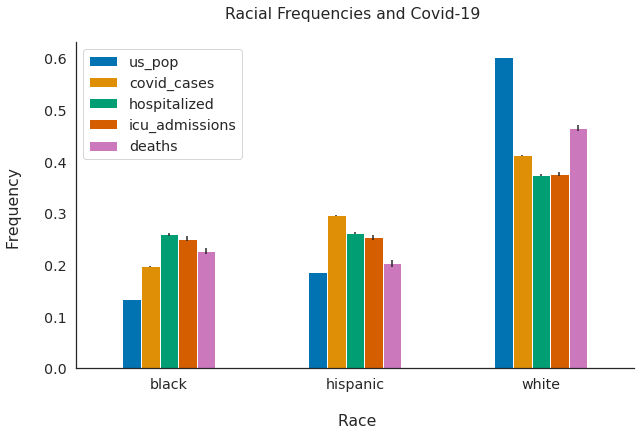

In [ ]:
#Create plot of entire dataframe

#Use a colorblind color palette
sns.set_palette('colorblind')

#Increase font size a bit
sns.set_context('notebook', font_scale=1.3)

#Adjust figure size
plt.rcParams["figure.figsize"] = [10, 6]

#Create Plot
racial_freq.plot(kind="bar", yerr = y_err_all)

#Set Labels
plt.title("Racial Frequencies and Covid-19 \n")
plt.xlabel("\n Race")
plt.ylabel("Frequency \n")
#Labels were defaulting to 90, so I am setting them back to 0
plt.xticks(rotation=0)

#Despine the plot... I like this appearance better
sns.despine()

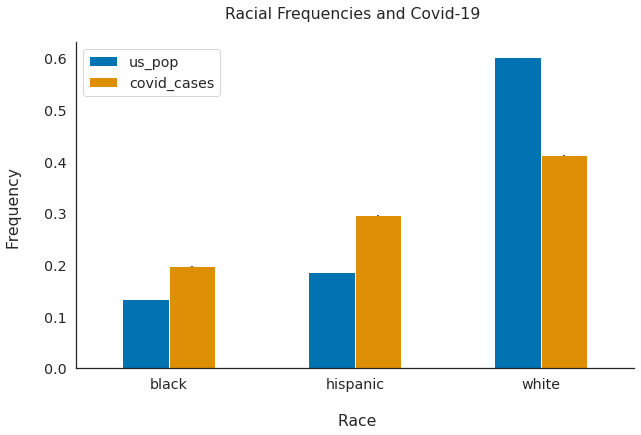

In [ ]:
#Plot just Covid Cases vs population
racial_freq.plot(x='race', y=['us_pop', 'covid_cases'], kind="bar", yerr= y_err_pc)

#format title and labels
plt.title("Racial Frequencies and Covid-19 \n")
plt.xlabel("\n Race")
plt.ylabel("Frequency \n")
#Labels were defaulting to 90, so I am setting them back to 0
plt.xticks(rotation=0)

#Despine the plot... I like this appearance better
sns.despine()

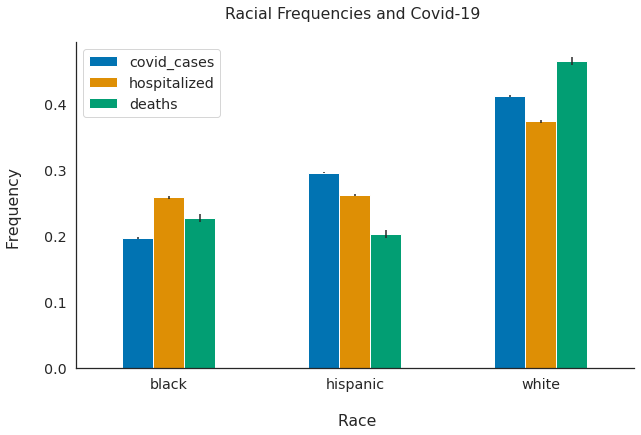

In [ ]:
#Plot just Covid Case, hospitalization, and death
racial_freq.plot(x='race', y=['covid_cases', 'hospitalized', 'deaths'], 
                 kind="bar", yerr= y_err_chd)

#format title and labels
plt.title("Racial Frequencies and Covid-19 \n")
plt.xlabel("\n Race")
plt.ylabel("Frequency \n")
#Labels were defaulting to 90, so I am setting them back to 0
plt.xticks(rotation=0)

#Despine the plot... I like this appearance better
sns.despine()


#Conclusions, Findings, and Recommendations
---
##Hypothesis 1: Covid cases increase in correlation with relaxing covid-19 behaviors

* This hypothesis was NOT supported by the data.  No significant correlation between case count and behaviors was found. 

###Future directions: 
Look for insights within the data set using symptom reporting responses to gain insight into behaviors vs sickness. 

---
##Hypothesis 2: POC are impacted more strongly by covid-19, as measured by hospitalization, ICU admission, and death rates.

* This hypothesis IS supported by the data. Black (high), Hispanic (high), and White (low) populations showed a significant difference between population frequency and covid case frequency. 

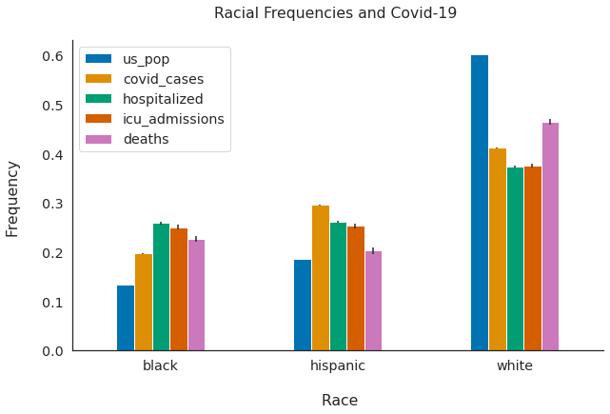

###Future Directions: 
Investigate *why* POC are impacted more negatively. Hypotheis: greater component of essential workforce.

Investigate gender and age differences, and look to see if the data can explain data trends such as white covid patients dying at a higher than expected rate, and why hispanic covid patients have lower ICU and death rates. 

---
##Recommendations
* Improve access to protective equipment in communities
* Improve access to Covid-19 testing to limit spread
* Provide sick leave so that employees don't spread the virus